# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
huma_profiles = np.array(glob("human_profiles/*"))
dog_profiles = np.array(glob("dog_profiles/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 3


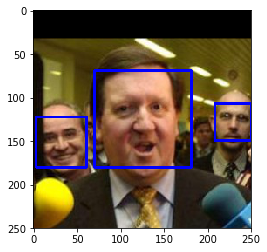

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    normalizedImg = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ I am not sure I got the question right because 98 percent is really big thing. I got 98 percent correct guess for human and 10 percent for false positive gussing human when image is dog

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
human_guess = 0
dog_guess = 0
type_one = 0
type_two = 0
for i in range(len(human_files_short)):
    if(face_detector(human_files_short[i])):
        human_guess +=1
for i in range(len(dog_files_short)):
    if(face_detector(dog_files_short[i])):
        dog_guess +=1
print("Human Dectected: "+str(human_guess))
print("Dog Dectected: "+str(dog_guess))
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

Human Dectected: 98
Dog Dectected: 10


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ I blieve with accuracy of guessing human face with 99 percent is really good already. However, 11 percent false positive might not be an ideal solution. I think if we normalize the image around mean or standard deviation, I believe it would give a better result in calse of face is not clearly presented. In fact, I try to normalize the image before input into the system and reduce the false postive to 10 percent but it also reduce the accuracy of guessing human to 98 percent.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
# Try to use https://github.com/davidsandberg/facenet

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ Renet perform with amazing outcome of guessing 100 percent right with no false positvie at all. :)

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_guess = 0
dog_guess = 0
type_one = 0
type_two = 0
for i in range(len(human_files_short)):
    if(dog_detector(human_files_short[i])):
        human_guess +=1
for i in range(len(dog_files_short)):
    if(dog_detector(dog_files_short[i])):
        dog_guess +=1
print("Human Dectected: "+str(human_guess))
print("Dog Dectected: "+str(dog_guess))

Human Dectected: 0
Dog Dectected: 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 128.79it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I choose to form my CNN with three convolutional layers without dropout because I want to just test my NN to pass 1 percent which there is no way it can be overfitted. With last three layers composed of global average pooling layer and two fully connected layers. I use real activation all the way through except at the end because it is a classification problem (softmax). In term of kernel_size = 3, this is not my argument but as I read online, when we choose kernel size with odd size, it tends to learn the balance between left and the right size (purely based on the structure and how convolutional function work).

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(500,activation='relu'))
model.add(Dense(133,activation='softmax'))
### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               16500     
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 34s - loss: 4.8817 - acc: 0.0085 - val_loss: 4.8627 - val_acc: 0.0120
Epoch 2/10
6680/6680 [==============================] - 33s - loss: 4.8332 - acc: 0.0136 - val_loss: 4.8230 - val_acc: 0.0156
Epoch 3/10
6680/6680 [==============================] - 33s - loss: 4.7756 - acc: 0.0175 - val_loss: 4.7694 - val_acc: 0.0204
Epoch 4/10
6680/6680 [==============================] - 33s - loss: 4.7314 - acc: 0.0193 - val_loss: 4.7111 - val_acc: 0.0228
Epoch 5/10
6680/6680 [==============================] - 33s - loss: 4.6869 - acc: 0.0210 - val_loss: 4.6719 - val_acc: 0.0323
Epoch 6/10
6680/6680 [==============================] - 33s - loss: 4.6385 - acc: 0.0241 - val_loss: 4.6546 - val_acc: 0.0275
Epoch 7/10
6680/6680 [==============================] - 33s - loss: 4.5928 - acc: 0.0319 - val_loss: 4.6083 - val_acc: 0.0371
Epoch 8/10
6680/6680 [==============================] - 33s - loss: 4.5

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
# Compare test_target along y axis which is the label of the dog bread
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.4258%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()

VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
#print(train_VGG16.shape[1:])
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.9212 - acc: 0.1016 - val_loss: 11.6450 - val_acc: 0.1737
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 11.1813 - acc: 0.2422 - val_loss: 10.9953 - val_acc: 0.2503
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 10.6225 - acc: 0.2906 - val_loss: 10.5150 - val_acc: 0.2766
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 10.3129 - acc: 0.3240 - val_loss: 10.4981 - val_acc: 0.2766
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 10.0809 - acc: 0.3373 - val_loss: 10.1844 - val_acc: 0.3042
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.7874 - acc: 0.3564 - val_loss: 10.0777 - val_acc: 0.3054
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.6520 - acc: 0.3716 - val_loss: 9.8927 - val_acc: 0.3198
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.1914%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_model = bottleneck_features['train']
valid_model = bottleneck_features['valid']
test_model = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Instead of starting with gloverAveragePooling2D. I start with fully connected layer by frist reshaped the whole input to one dimensional tensor. The reason is I want to preserve all the information before start to fillter information by using globalAveragePooling2D. Then, I use purely fully connected with dropout following to avoid overfitting and improve the performance of guessing. I use relu all the way through except at the end I use softmax for classfication problem. I put an early stop warrning at with loss getting close to 0.0001. However, with eposed of 1000, it still not even close to get there. With additional 9 million parameter, somehow, my neural network stop with performing around 84 percent. My suspecision is that final output of Renest50 has a lot of information that not contributed to guessing a dog in general. I try to overfit the model to make sure the model have enough parameter to learn.

In [26]:
### TODO: Define your architecture.
from keras.layers import GlobalAveragePooling2D, Reshape,Flatten
choosing_model = Sequential()
#print(train_model.shape[1:])
#choosing_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
#choosing_model.add(GlobalAveragePooling2D(input_shape=train_model.shape[1:]))
choosing_model.add(Reshape((2048,),input_shape=train_model.shape[1:]))
choosing_model.add(Dense(3000, activation="relu"))
choosing_model.add(Dropout(0.3))
choosing_model.add(Dense(1000, activation="relu"))
choosing_model.add(Dropout(0.2))
choosing_model.add(Dense(500, activation="relu"))
#choosing_model.add(Conv2D(filters=16,kernel_size=3,padding='same',activation='relu',input_shape=train_model[1:]))
#print(len(Xception_model.shape[1:]))

choosing_model.add(Dense(133, activation='softmax'))
choosing_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3000)              6147000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 133)               66633     
Total para

In [27]:
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        choosing_model.add(Dropout(0.2))
        choosing_model.add(Dense(1000, activation="relu"))
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

### (IMPLEMENTATION) Compile the Model

In [28]:
### TODO: Compile the model.
from keras.optimizers import Adagrad,RMSprop
adagrad = Adagrad(lr=0.0001, epsilon=1e-08, decay=0.0)
rmpprop = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
choosing_model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 2s - loss: 4.7288 - acc: 0.0410 - val_loss: 4.4055 - val_acc: 0.1964
Epoch 2/1000
6680/6680 [==============================] - 1s - loss: 4.3303 - acc: 0.1352 - val_loss: 4.0384 - val_acc: 0.3305
Epoch 3/1000
6680/6680 [==============================] - 1s - loss: 4.0029 - acc: 0.2241 - val_loss: 3.6869 - val_acc: 0.4168
Epoch 4/1000
6680/6680 [==============================] - 1s - loss: 3.7011 - acc: 0.2957 - val_loss: 3.3578 - val_acc: 0.4838
Epoch 5/1000
6680/6680 [==============================] - 1s - loss: 3.4127 - acc: 0.3479 - val_loss: 3.0575 - val_acc: 0.5293
Epoch 6/1000
6680/6680 [==============================] - 1s - loss: 3.1455 - acc: 0.4015 - val_loss: 2.7899 - val_acc: 0.5497
Epoch 7/1000
6680/6680 [==============================] - 1s - loss: 2.9062 - acc: 0.4383 - val_loss: 2.5577 - val_acc: 0.5820
Epoch 8/1000
6680/6680 [==============================] - 1s - l

6680/6680 [==============================] - 1s - loss: 1.3253 - acc: 0.6843 - val_loss: 1.1383 - val_acc: 0.7341
Epoch 27/1000
6680/6680 [==============================] - 1s - loss: 1.3020 - acc: 0.6837 - val_loss: 1.1161 - val_acc: 0.7449
Epoch 28/1000
6680/6680 [==============================] - 1s - loss: 1.2829 - acc: 0.6787 - val_loss: 1.0943 - val_acc: 0.7437
Epoch 29/1000
6680/6680 [==============================] - 1s - loss: 1.2497 - acc: 0.6891 - val_loss: 1.0795 - val_acc: 0.7401
Epoch 30/1000
6680/6680 [==============================] - 1s - loss: 1.2187 - acc: 0.6984 - val_loss: 1.0592 - val_acc: 0.7437
Epoch 31/1000
6680/6680 [==============================] - 1s - loss: 1.1990 - acc: 0.7036 - val_loss: 1.0428 - val_acc: 0.7485
Epoch 32/1000
6680/6680 [==============================] - 1s - loss: 1.1820 - acc: 0.7106 - val_loss: 1.0278 - val_acc: 0.7521
Epoch 33/1000
6680/6680 [==============================] - 1s - loss: 1.1748 - acc: 0.7046 - val_loss: 1.0139 - val_ac

6680/6680 [==============================] - 1s - loss: 0.8867 - acc: 0.7722 - val_loss: 0.8412 - val_acc: 0.7892
Epoch 53/1000
6680/6680 [==============================] - 1s - loss: 0.8749 - acc: 0.7737 - val_loss: 0.8338 - val_acc: 0.7832
Epoch 54/1000
6680/6680 [==============================] - 1s - loss: 0.8672 - acc: 0.7772 - val_loss: 0.8285 - val_acc: 0.7868
Epoch 55/1000
6680/6680 [==============================] - 1s - loss: 0.8660 - acc: 0.7746 - val_loss: 0.8247 - val_acc: 0.7856
Epoch 56/1000
6680/6680 [==============================] - 1s - loss: 0.8774 - acc: 0.7654 - val_loss: 0.8184 - val_acc: 0.7916
Epoch 57/1000
6680/6680 [==============================] - 1s - loss: 0.8589 - acc: 0.7746 - val_loss: 0.8124 - val_acc: 0.7928
Epoch 58/1000
6680/6680 [==============================] - 1s - loss: 0.8489 - acc: 0.7778 - val_loss: 0.8079 - val_acc: 0.7928
Epoch 59/1000
6680/6680 [==============================] - 1s - loss: 0.8304 - acc: 0.7804 - val_loss: 0.8021 - val_ac

6680/6680 [==============================] - 1s - loss: 0.7233 - acc: 0.8051 - val_loss: 0.7365 - val_acc: 0.7988
Epoch 78/1000
6680/6680 [==============================] - 1s - loss: 0.7223 - acc: 0.8004 - val_loss: 0.7330 - val_acc: 0.8024
Epoch 79/1000
6680/6680 [==============================] - 1s - loss: 0.7235 - acc: 0.8103 - val_loss: 0.7300 - val_acc: 0.8024
Epoch 80/1000
6680/6680 [==============================] - 1s - loss: 0.7007 - acc: 0.8174 - val_loss: 0.7283 - val_acc: 0.8048
Epoch 81/1000
6680/6680 [==============================] - 1s - loss: 0.7047 - acc: 0.8156 - val_loss: 0.7246 - val_acc: 0.8060
Epoch 82/1000
6680/6680 [==============================] - 1s - loss: 0.6975 - acc: 0.8126 - val_loss: 0.7227 - val_acc: 0.8036
Epoch 83/1000
6680/6680 [==============================] - 1s - loss: 0.7045 - acc: 0.8126 - val_loss: 0.7200 - val_acc: 0.8024
Epoch 84/1000
6680/6680 [==============================] - 1s - loss: 0.6994 - acc: 0.8184 - val_loss: 0.7180 - val_ac

6680/6680 [==============================] - 1s - loss: 0.6260 - acc: 0.8347 - val_loss: 0.6799 - val_acc: 0.8180
Epoch 104/1000
6680/6680 [==============================] - 1s - loss: 0.6086 - acc: 0.8329 - val_loss: 0.6784 - val_acc: 0.8144
Epoch 105/1000
6680/6680 [==============================] - 1s - loss: 0.6042 - acc: 0.8373 - val_loss: 0.6757 - val_acc: 0.8156
Epoch 106/1000
6680/6680 [==============================] - 1s - loss: 0.6063 - acc: 0.8442 - val_loss: 0.6743 - val_acc: 0.8180
Epoch 107/1000
6680/6680 [==============================] - 1s - loss: 0.5961 - acc: 0.8398 - val_loss: 0.6733 - val_acc: 0.8204
Epoch 108/1000
6680/6680 [==============================] - 1s - loss: 0.6204 - acc: 0.8329 - val_loss: 0.6721 - val_acc: 0.8132
Epoch 109/1000
6680/6680 [==============================] - 1s - loss: 0.5949 - acc: 0.8367 - val_loss: 0.6702 - val_acc: 0.8180
Epoch 110/1000
6680/6680 [==============================] - 1s - loss: 0.5860 - acc: 0.8418 - val_loss: 0.6692 -

6680/6680 [==============================] - 1s - loss: 0.5518 - acc: 0.8494 - val_loss: 0.6443 - val_acc: 0.8251
Epoch 129/1000
6680/6680 [==============================] - 1s - loss: 0.5482 - acc: 0.8519 - val_loss: 0.6437 - val_acc: 0.8251
Epoch 130/1000
6680/6680 [==============================] - 1s - loss: 0.5419 - acc: 0.8564 - val_loss: 0.6427 - val_acc: 0.8275
Epoch 131/1000
6680/6680 [==============================] - 1s - loss: 0.5520 - acc: 0.8485 - val_loss: 0.6413 - val_acc: 0.8311
Epoch 132/1000
6680/6680 [==============================] - 1s - loss: 0.5428 - acc: 0.8576 - val_loss: 0.6410 - val_acc: 0.8311
Epoch 133/1000
6680/6680 [==============================] - 1s - loss: 0.5394 - acc: 0.8594 - val_loss: 0.6398 - val_acc: 0.8311
Epoch 134/1000
6680/6680 [==============================] - 1s - loss: 0.5307 - acc: 0.8579 - val_loss: 0.6390 - val_acc: 0.8311
Epoch 135/1000
6680/6680 [==============================] - 1s - loss: 0.5310 - acc: 0.8582 - val_loss: 0.6380 -

6680/6680 [==============================] - 1s - loss: 0.4736 - acc: 0.8753 - val_loss: 0.6201 - val_acc: 0.8311
Epoch 155/1000
6680/6680 [==============================] - 1s - loss: 0.4866 - acc: 0.8674 - val_loss: 0.6191 - val_acc: 0.8299
Epoch 156/1000
6680/6680 [==============================] - 1s - loss: 0.4972 - acc: 0.8597 - val_loss: 0.6183 - val_acc: 0.8359
Epoch 157/1000
6680/6680 [==============================] - 1s - loss: 0.4911 - acc: 0.8675 - val_loss: 0.6171 - val_acc: 0.8323
Epoch 158/1000
6680/6680 [==============================] - 1s - loss: 0.4791 - acc: 0.8692 - val_loss: 0.6161 - val_acc: 0.8311
Epoch 159/1000
6680/6680 [==============================] - 1s - loss: 0.4863 - acc: 0.8702 - val_loss: 0.6158 - val_acc: 0.8323
Epoch 160/1000
6680/6680 [==============================] - 1s - loss: 0.4689 - acc: 0.8774 - val_loss: 0.6151 - val_acc: 0.8335
Epoch 161/1000
6680/6680 [==============================] - 1s - loss: 0.4799 - acc: 0.8738 - val_loss: 0.6130 -

6680/6680 [==============================] - 1s - loss: 0.4516 - acc: 0.8774 - val_loss: 0.6021 - val_acc: 0.8407
Epoch 180/1000
6680/6680 [==============================] - 1s - loss: 0.4390 - acc: 0.8870 - val_loss: 0.6006 - val_acc: 0.8359
Epoch 181/1000
6680/6680 [==============================] - 1s - loss: 0.4426 - acc: 0.8816 - val_loss: 0.6003 - val_acc: 0.8347
Epoch 182/1000
6680/6680 [==============================] - 1s - loss: 0.4355 - acc: 0.8865 - val_loss: 0.5991 - val_acc: 0.8371
Epoch 183/1000
6680/6680 [==============================] - 1s - loss: 0.4398 - acc: 0.8813 - val_loss: 0.5986 - val_acc: 0.8347
Epoch 184/1000
6680/6680 [==============================] - 1s - loss: 0.4462 - acc: 0.8819 - val_loss: 0.5982 - val_acc: 0.8383
Epoch 185/1000
6680/6680 [==============================] - 1s - loss: 0.4372 - acc: 0.8813 - val_loss: 0.5974 - val_acc: 0.8407
Epoch 186/1000
6680/6680 [==============================] - 1s - loss: 0.4400 - acc: 0.8828 - val_loss: 0.5968 -

6680/6680 [==============================] - 1s - loss: 0.4084 - acc: 0.8888 - val_loss: 0.5848 - val_acc: 0.8383
Epoch 207/1000
6680/6680 [==============================] - 1s - loss: 0.4184 - acc: 0.8867 - val_loss: 0.5844 - val_acc: 0.8407
Epoch 208/1000
6680/6680 [==============================] - 1s - loss: 0.3979 - acc: 0.8987 - val_loss: 0.5849 - val_acc: 0.8419
Epoch 209/1000
6680/6680 [==============================] - 1s - loss: 0.4114 - acc: 0.8865 - val_loss: 0.5851 - val_acc: 0.8395
Epoch 210/1000
6680/6680 [==============================] - 1s - loss: 0.4031 - acc: 0.8898 - val_loss: 0.5850 - val_acc: 0.8419
Epoch 211/1000
6680/6680 [==============================] - 1s - loss: 0.4073 - acc: 0.8928 - val_loss: 0.5838 - val_acc: 0.8455
Epoch 212/1000
6680/6680 [==============================] - 1s - loss: 0.4021 - acc: 0.8913 - val_loss: 0.5832 - val_acc: 0.8455
Epoch 213/1000
6680/6680 [==============================] - 1s - loss: 0.3966 - acc: 0.8988 - val_loss: 0.5829 -

6680/6680 [==============================] - 1s - loss: 0.3807 - acc: 0.8960 - val_loss: 0.5734 - val_acc: 0.8419
Epoch 234/1000
6680/6680 [==============================] - 1s - loss: 0.3883 - acc: 0.8981 - val_loss: 0.5722 - val_acc: 0.8443
Epoch 235/1000
6680/6680 [==============================] - 1s - loss: 0.3799 - acc: 0.8993 - val_loss: 0.5722 - val_acc: 0.8455
Epoch 236/1000
6680/6680 [==============================] - 1s - loss: 0.3774 - acc: 0.9004 - val_loss: 0.5718 - val_acc: 0.8419
Epoch 237/1000
6680/6680 [==============================] - 1s - loss: 0.3736 - acc: 0.8987 - val_loss: 0.5724 - val_acc: 0.8419
Epoch 238/1000
6680/6680 [==============================] - 1s - loss: 0.3776 - acc: 0.9006 - val_loss: 0.5722 - val_acc: 0.8419
Epoch 239/1000
6680/6680 [==============================] - 1s - loss: 0.3830 - acc: 0.8969 - val_loss: 0.5722 - val_acc: 0.8407
Epoch 240/1000
6680/6680 [==============================] - 1s - loss: 0.3726 - acc: 0.9006 - val_loss: 0.5719 -

6680/6680 [==============================] - 1s - loss: 0.3678 - acc: 0.9028 - val_loss: 0.5654 - val_acc: 0.8407
Epoch 261/1000
6680/6680 [==============================] - 1s - loss: 0.3506 - acc: 0.9066 - val_loss: 0.5656 - val_acc: 0.8407
Epoch 262/1000
6680/6680 [==============================] - 1s - loss: 0.3529 - acc: 0.9055 - val_loss: 0.5649 - val_acc: 0.8431
Epoch 263/1000
6680/6680 [==============================] - 1s - loss: 0.3536 - acc: 0.9066 - val_loss: 0.5642 - val_acc: 0.8443
Epoch 264/1000
6680/6680 [==============================] - 1s - loss: 0.3551 - acc: 0.9082 - val_loss: 0.5640 - val_acc: 0.8455
Epoch 265/1000
6680/6680 [==============================] - 1s - loss: 0.3499 - acc: 0.9082 - val_loss: 0.5636 - val_acc: 0.8467
Epoch 266/1000
6680/6680 [==============================] - 1s - loss: 0.3442 - acc: 0.9106 - val_loss: 0.5632 - val_acc: 0.8431
Epoch 267/1000
6680/6680 [==============================] - 1s - loss: 0.3512 - acc: 0.9093 - val_loss: 0.5627 -

6680/6680 [==============================] - 1s - loss: 0.3396 - acc: 0.9103 - val_loss: 0.5575 - val_acc: 0.8467
Epoch 289/1000
6680/6680 [==============================] - 1s - loss: 0.3294 - acc: 0.9120 - val_loss: 0.5564 - val_acc: 0.8467
Epoch 290/1000
6680/6680 [==============================] - 1s - loss: 0.3315 - acc: 0.9132 - val_loss: 0.5563 - val_acc: 0.8467
Epoch 291/1000
6680/6680 [==============================] - 1s - loss: 0.3260 - acc: 0.9165 - val_loss: 0.5563 - val_acc: 0.8455
Epoch 292/1000
6680/6680 [==============================] - 1s - loss: 0.3307 - acc: 0.9165 - val_loss: 0.5560 - val_acc: 0.8443
Epoch 293/1000
6680/6680 [==============================] - 1s - loss: 0.3260 - acc: 0.9163 - val_loss: 0.5563 - val_acc: 0.8467
Epoch 294/1000
6680/6680 [==============================] - 1s - loss: 0.3362 - acc: 0.9097 - val_loss: 0.5557 - val_acc: 0.8467
Epoch 295/1000
6680/6680 [==============================] - 1s - loss: 0.3201 - acc: 0.9171 - val_loss: 0.5558 -

6680/6680 [==============================] - 1s - loss: 0.3069 - acc: 0.9214 - val_loss: 0.5499 - val_acc: 0.8479
Epoch 317/1000
6680/6680 [==============================] - 1s - loss: 0.3171 - acc: 0.9186 - val_loss: 0.5494 - val_acc: 0.8467
Epoch 318/1000
6680/6680 [==============================] - 1s - loss: 0.3056 - acc: 0.9226 - val_loss: 0.5490 - val_acc: 0.8467
Epoch 319/1000
6680/6680 [==============================] - 1s - loss: 0.3177 - acc: 0.9177 - val_loss: 0.5491 - val_acc: 0.8479
Epoch 320/1000
6680/6680 [==============================] - 1s - loss: 0.3203 - acc: 0.9157 - val_loss: 0.5482 - val_acc: 0.8503
Epoch 321/1000
6680/6680 [==============================] - 1s - loss: 0.3103 - acc: 0.9187 - val_loss: 0.5482 - val_acc: 0.8455
Epoch 322/1000
6680/6680 [==============================] - 1s - loss: 0.3149 - acc: 0.9178 - val_loss: 0.5482 - val_acc: 0.8455
Epoch 323/1000
6680/6680 [==============================] - 1s - loss: 0.3036 - acc: 0.9217 - val_loss: 0.5480 -

6680/6680 [==============================] - 1s - loss: 0.2984 - acc: 0.9254 - val_loss: 0.5442 - val_acc: 0.8491
Epoch 345/1000
6680/6680 [==============================] - 1s - loss: 0.2949 - acc: 0.9257 - val_loss: 0.5446 - val_acc: 0.8491
Epoch 346/1000
6680/6680 [==============================] - 1s - loss: 0.2978 - acc: 0.9226 - val_loss: 0.5442 - val_acc: 0.8503
Epoch 347/1000
6680/6680 [==============================] - 1s - loss: 0.2898 - acc: 0.9278 - val_loss: 0.5444 - val_acc: 0.8467
Epoch 348/1000
6680/6680 [==============================] - 1s - loss: 0.2926 - acc: 0.9195 - val_loss: 0.5435 - val_acc: 0.8467
Epoch 349/1000
6680/6680 [==============================] - 1s - loss: 0.2957 - acc: 0.9260 - val_loss: 0.5435 - val_acc: 0.8491
Epoch 350/1000
6680/6680 [==============================] - 1s - loss: 0.2913 - acc: 0.9247 - val_loss: 0.5426 - val_acc: 0.8503
Epoch 351/1000
6680/6680 [==============================] - 1s - loss: 0.2932 - acc: 0.9249 - val_loss: 0.5430 -

6680/6680 [==============================] - 1s - loss: 0.2782 - acc: 0.9307 - val_loss: 0.5387 - val_acc: 0.8503
Epoch 372/1000
6680/6680 [==============================] - 1s - loss: 0.2827 - acc: 0.9241 - val_loss: 0.5391 - val_acc: 0.8491
Epoch 373/1000
6680/6680 [==============================] - 1s - loss: 0.2829 - acc: 0.9278 - val_loss: 0.5393 - val_acc: 0.8503
Epoch 374/1000
6680/6680 [==============================] - 1s - loss: 0.2725 - acc: 0.9310 - val_loss: 0.5394 - val_acc: 0.8479
Epoch 375/1000
6680/6680 [==============================] - 1s - loss: 0.2780 - acc: 0.9281 - val_loss: 0.5388 - val_acc: 0.8467
Epoch 376/1000
6680/6680 [==============================] - 1s - loss: 0.2850 - acc: 0.9283 - val_loss: 0.5382 - val_acc: 0.8491
Epoch 377/1000
6680/6680 [==============================] - 1s - loss: 0.2716 - acc: 0.9299 - val_loss: 0.5385 - val_acc: 0.8503
Epoch 378/1000
6680/6680 [==============================] - 1s - loss: 0.2759 - acc: 0.9326 - val_loss: 0.5384 -

6680/6680 [==============================] - 1s - loss: 0.2640 - acc: 0.9319 - val_loss: 0.5354 - val_acc: 0.8467
Epoch 402/1000
6680/6680 [==============================] - 1s - loss: 0.2654 - acc: 0.9311 - val_loss: 0.5347 - val_acc: 0.8455
Epoch 403/1000
6680/6680 [==============================] - 1s - loss: 0.2567 - acc: 0.9371 - val_loss: 0.5350 - val_acc: 0.8467
Epoch 404/1000
6680/6680 [==============================] - 1s - loss: 0.2583 - acc: 0.9367 - val_loss: 0.5346 - val_acc: 0.8491
Epoch 405/1000
6680/6680 [==============================] - 1s - loss: 0.2599 - acc: 0.9356 - val_loss: 0.5342 - val_acc: 0.8491
Epoch 406/1000
6680/6680 [==============================] - 1s - loss: 0.2624 - acc: 0.9338 - val_loss: 0.5339 - val_acc: 0.8467
Epoch 407/1000
6680/6680 [==============================] - 1s - loss: 0.2581 - acc: 0.9364 - val_loss: 0.5335 - val_acc: 0.8503
Epoch 408/1000
6680/6680 [==============================] - 1s - loss: 0.2572 - acc: 0.9380 - val_loss: 0.5335 -

6680/6680 [==============================] - 1s - loss: 0.2481 - acc: 0.9401 - val_loss: 0.5309 - val_acc: 0.8515
Epoch 431/1000
6680/6680 [==============================] - 1s - loss: 0.2496 - acc: 0.9388 - val_loss: 0.5301 - val_acc: 0.8515
Epoch 432/1000
6680/6680 [==============================] - 1s - loss: 0.2458 - acc: 0.9371 - val_loss: 0.5304 - val_acc: 0.8527
Epoch 433/1000
6680/6680 [==============================] - 1s - loss: 0.2530 - acc: 0.9364 - val_loss: 0.5308 - val_acc: 0.8503
Epoch 434/1000
6680/6680 [==============================] - 1s - loss: 0.2531 - acc: 0.9329 - val_loss: 0.5303 - val_acc: 0.8515
Epoch 435/1000
6680/6680 [==============================] - 1s - loss: 0.2483 - acc: 0.9365 - val_loss: 0.5297 - val_acc: 0.8515
Epoch 436/1000
6680/6680 [==============================] - 1s - loss: 0.2433 - acc: 0.9427 - val_loss: 0.5298 - val_acc: 0.8515
Epoch 437/1000
6680/6680 [==============================] - 1s - loss: 0.2344 - acc: 0.9440 - val_loss: 0.5301 -

6680/6680 [==============================] - 1s - loss: 0.2389 - acc: 0.9436 - val_loss: 0.5269 - val_acc: 0.8491
Epoch 460/1000
6680/6680 [==============================] - 1s - loss: 0.2395 - acc: 0.9398 - val_loss: 0.5265 - val_acc: 0.8515
Epoch 461/1000
6680/6680 [==============================] - 1s - loss: 0.2387 - acc: 0.9443 - val_loss: 0.5263 - val_acc: 0.8515
Epoch 462/1000
6680/6680 [==============================] - 1s - loss: 0.2430 - acc: 0.9365 - val_loss: 0.5264 - val_acc: 0.8539
Epoch 463/1000
6680/6680 [==============================] - 1s - loss: 0.2383 - acc: 0.9394 - val_loss: 0.5269 - val_acc: 0.8527
Epoch 464/1000
6680/6680 [==============================] - 1s - loss: 0.2373 - acc: 0.9403 - val_loss: 0.5270 - val_acc: 0.8527
Epoch 465/1000
6680/6680 [==============================] - 1s - loss: 0.2433 - acc: 0.9382 - val_loss: 0.5275 - val_acc: 0.8515
Epoch 466/1000
6680/6680 [==============================] - 1s - loss: 0.2375 - acc: 0.9407 - val_loss: 0.5277 -

6680/6680 [==============================] - 1s - loss: 0.2229 - acc: 0.9485 - val_loss: 0.5244 - val_acc: 0.8515
Epoch 490/1000
6680/6680 [==============================] - 1s - loss: 0.2356 - acc: 0.9377 - val_loss: 0.5248 - val_acc: 0.8515
Epoch 491/1000
6680/6680 [==============================] - 1s - loss: 0.2239 - acc: 0.9466 - val_loss: 0.5245 - val_acc: 0.8503
Epoch 492/1000
6680/6680 [==============================] - 1s - loss: 0.2277 - acc: 0.9454 - val_loss: 0.5247 - val_acc: 0.8515
Epoch 493/1000
6680/6680 [==============================] - 1s - loss: 0.2264 - acc: 0.9406 - val_loss: 0.5254 - val_acc: 0.8515
Epoch 494/1000
6680/6680 [==============================] - 1s - loss: 0.2315 - acc: 0.9407 - val_loss: 0.5252 - val_acc: 0.8503
Epoch 495/1000
6680/6680 [==============================] - 1s - loss: 0.2185 - acc: 0.9470 - val_loss: 0.5251 - val_acc: 0.8515
Epoch 496/1000
6680/6680 [==============================] - 1s - loss: 0.2257 - acc: 0.9433 - val_loss: 0.5249 -

6680/6680 [==============================] - 1s - loss: 0.2143 - acc: 0.9503 - val_loss: 0.5228 - val_acc: 0.8515
Epoch 521/1000
6680/6680 [==============================] - 1s - loss: 0.2176 - acc: 0.9472 - val_loss: 0.5227 - val_acc: 0.8515
Epoch 522/1000
6680/6680 [==============================] - 1s - loss: 0.2151 - acc: 0.9488 - val_loss: 0.5228 - val_acc: 0.8539
Epoch 523/1000
6680/6680 [==============================] - 1s - loss: 0.2216 - acc: 0.9446 - val_loss: 0.5229 - val_acc: 0.8539
Epoch 524/1000
6680/6680 [==============================] - 1s - loss: 0.2299 - acc: 0.9404 - val_loss: 0.5226 - val_acc: 0.8515
Epoch 525/1000
6680/6680 [==============================] - 1s - loss: 0.2136 - acc: 0.9512 - val_loss: 0.5223 - val_acc: 0.8539
Epoch 526/1000
6680/6680 [==============================] - 1s - loss: 0.2129 - acc: 0.9488 - val_loss: 0.5222 - val_acc: 0.8527
Epoch 527/1000
6680/6680 [==============================] - 1s - loss: 0.2116 - acc: 0.9487 - val_loss: 0.5220 -

6680/6680 [==============================] - 1s - loss: 0.2059 - acc: 0.9545 - val_loss: 0.5192 - val_acc: 0.8539
Epoch 550/1000
6680/6680 [==============================] - 1s - loss: 0.2152 - acc: 0.9457 - val_loss: 0.5193 - val_acc: 0.8503
Epoch 551/1000
6680/6680 [==============================] - 1s - loss: 0.2050 - acc: 0.9518 - val_loss: 0.5195 - val_acc: 0.8503
Epoch 552/1000
6680/6680 [==============================] - 1s - loss: 0.2074 - acc: 0.9487 - val_loss: 0.5192 - val_acc: 0.8539
Epoch 553/1000
6680/6680 [==============================] - 1s - loss: 0.2094 - acc: 0.9499 - val_loss: 0.5187 - val_acc: 0.8503
Epoch 554/1000
6680/6680 [==============================] - 1s - loss: 0.2144 - acc: 0.9469 - val_loss: 0.5189 - val_acc: 0.8539
Epoch 555/1000
6680/6680 [==============================] - 1s - loss: 0.2100 - acc: 0.9490 - val_loss: 0.5191 - val_acc: 0.8503
Epoch 556/1000
6680/6680 [==============================] - 1s - loss: 0.2098 - acc: 0.9484 - val_loss: 0.5186 -

6680/6680 [==============================] - 1s - loss: 0.2026 - acc: 0.9537 - val_loss: 0.5177 - val_acc: 0.8503
Epoch 580/1000
6680/6680 [==============================] - 1s - loss: 0.2037 - acc: 0.9527 - val_loss: 0.5179 - val_acc: 0.8527
Epoch 581/1000
6680/6680 [==============================] - 1s - loss: 0.2015 - acc: 0.9522 - val_loss: 0.5171 - val_acc: 0.8515
Epoch 582/1000
6680/6680 [==============================] - 1s - loss: 0.2014 - acc: 0.9488 - val_loss: 0.5173 - val_acc: 0.8515
Epoch 583/1000
6680/6680 [==============================] - 1s - loss: 0.1992 - acc: 0.9546 - val_loss: 0.5170 - val_acc: 0.8515
Epoch 584/1000
6680/6680 [==============================] - 1s - loss: 0.2015 - acc: 0.9549 - val_loss: 0.5170 - val_acc: 0.8527
Epoch 585/1000
6680/6680 [==============================] - 1s - loss: 0.1960 - acc: 0.9536 - val_loss: 0.5171 - val_acc: 0.8527
Epoch 586/1000
6680/6680 [==============================] - 1s - loss: 0.1990 - acc: 0.9497 - val_loss: 0.5167 -

6680/6680 [==============================] - 1s - loss: 0.1923 - acc: 0.9555 - val_loss: 0.5163 - val_acc: 0.8515
Epoch 612/1000
6680/6680 [==============================] - 1s - loss: 0.1933 - acc: 0.9542 - val_loss: 0.5164 - val_acc: 0.8527
Epoch 613/1000
6680/6680 [==============================] - 1s - loss: 0.1992 - acc: 0.9521 - val_loss: 0.5163 - val_acc: 0.8515
Epoch 614/1000
6680/6680 [==============================] - 1s - loss: 0.1885 - acc: 0.9570 - val_loss: 0.5158 - val_acc: 0.8479
Epoch 615/1000
6680/6680 [==============================] - 1s - loss: 0.1970 - acc: 0.9512 - val_loss: 0.5162 - val_acc: 0.8479
Epoch 616/1000
6680/6680 [==============================] - 1s - loss: 0.1913 - acc: 0.9555 - val_loss: 0.5166 - val_acc: 0.8467
Epoch 617/1000
6680/6680 [==============================] - 1s - loss: 0.1881 - acc: 0.9554 - val_loss: 0.5164 - val_acc: 0.8491
Epoch 618/1000
6680/6680 [==============================] - 1s - loss: 0.1976 - acc: 0.9516 - val_loss: 0.5161 -

6680/6680 [==============================] - 1s - loss: 0.1872 - acc: 0.9555 - val_loss: 0.5153 - val_acc: 0.8467
Epoch 643/1000
6680/6680 [==============================] - 1s - loss: 0.1951 - acc: 0.9504 - val_loss: 0.5152 - val_acc: 0.8491
Epoch 644/1000
6680/6680 [==============================] - 1s - loss: 0.1878 - acc: 0.9558 - val_loss: 0.5152 - val_acc: 0.8491
Epoch 645/1000
6680/6680 [==============================] - 1s - loss: 0.1855 - acc: 0.9585 - val_loss: 0.5152 - val_acc: 0.8479
Epoch 646/1000
6680/6680 [==============================] - 1s - loss: 0.1871 - acc: 0.9561 - val_loss: 0.5148 - val_acc: 0.8479
Epoch 647/1000
6680/6680 [==============================] - 1s - loss: 0.1873 - acc: 0.9567 - val_loss: 0.5146 - val_acc: 0.8503
Epoch 648/1000
6680/6680 [==============================] - 1s - loss: 0.1821 - acc: 0.9600 - val_loss: 0.5145 - val_acc: 0.8479
Epoch 649/1000
6680/6680 [==============================] - 1s - loss: 0.1845 - acc: 0.9575 - val_loss: 0.5146 -

6680/6680 [==============================] - 1s - loss: 0.1788 - acc: 0.9596 - val_loss: 0.5126 - val_acc: 0.8503
Epoch 672/1000
6680/6680 [==============================] - 1s - loss: 0.1798 - acc: 0.9584 - val_loss: 0.5126 - val_acc: 0.8503
Epoch 673/1000
6680/6680 [==============================] - 1s - loss: 0.1755 - acc: 0.9606 - val_loss: 0.5131 - val_acc: 0.8503
Epoch 674/1000
6680/6680 [==============================] - 1s - loss: 0.1717 - acc: 0.9645 - val_loss: 0.5137 - val_acc: 0.8503
Epoch 675/1000
6680/6680 [==============================] - 1s - loss: 0.1769 - acc: 0.9605 - val_loss: 0.5139 - val_acc: 0.8503
Epoch 676/1000
6680/6680 [==============================] - 1s - loss: 0.1794 - acc: 0.9566 - val_loss: 0.5136 - val_acc: 0.8503
Epoch 677/1000
6680/6680 [==============================] - 1s - loss: 0.1753 - acc: 0.9597 - val_loss: 0.5135 - val_acc: 0.8491
Epoch 678/1000
6680/6680 [==============================] - 1s - loss: 0.1782 - acc: 0.9567 - val_loss: 0.5133 -

6680/6680 [==============================] - 1s - loss: 0.1732 - acc: 0.9581 - val_loss: 0.5115 - val_acc: 0.8491
Epoch 703/1000
6680/6680 [==============================] - 1s - loss: 0.1743 - acc: 0.9621 - val_loss: 0.5114 - val_acc: 0.8491
Epoch 704/1000
6680/6680 [==============================] - 1s - loss: 0.1729 - acc: 0.9576 - val_loss: 0.5113 - val_acc: 0.8503
Epoch 705/1000
6680/6680 [==============================] - 1s - loss: 0.1755 - acc: 0.9591 - val_loss: 0.5111 - val_acc: 0.8479
Epoch 706/1000
6680/6680 [==============================] - 1s - loss: 0.1687 - acc: 0.9626 - val_loss: 0.5111 - val_acc: 0.8503
Epoch 707/1000
6680/6680 [==============================] - 1s - loss: 0.1728 - acc: 0.9621 - val_loss: 0.5112 - val_acc: 0.8491
Epoch 708/1000
6680/6680 [==============================] - 1s - loss: 0.1729 - acc: 0.9626 - val_loss: 0.5113 - val_acc: 0.8491
Epoch 709/1000
6680/6680 [==============================] - 1s - loss: 0.1707 - acc: 0.9623 - val_loss: 0.5117 -

6680/6680 [==============================] - 1s - loss: 0.1642 - acc: 0.9626 - val_loss: 0.5106 - val_acc: 0.8491
Epoch 734/1000
6680/6680 [==============================] - 1s - loss: 0.1648 - acc: 0.9651 - val_loss: 0.5105 - val_acc: 0.8491
Epoch 735/1000
6680/6680 [==============================] - 1s - loss: 0.1664 - acc: 0.9618 - val_loss: 0.5112 - val_acc: 0.8491
Epoch 736/1000
6680/6680 [==============================] - 1s - loss: 0.1618 - acc: 0.9618 - val_loss: 0.5111 - val_acc: 0.8551
Epoch 737/1000
6680/6680 [==============================] - 1s - loss: 0.1643 - acc: 0.9617 - val_loss: 0.5112 - val_acc: 0.8527
Epoch 738/1000
6680/6680 [==============================] - 1s - loss: 0.1657 - acc: 0.9653 - val_loss: 0.5113 - val_acc: 0.8515
Epoch 739/1000
6680/6680 [==============================] - 1s - loss: 0.1655 - acc: 0.9614 - val_loss: 0.5112 - val_acc: 0.8515
Epoch 740/1000
6680/6680 [==============================] - 1s - loss: 0.1703 - acc: 0.9579 - val_loss: 0.5105 -

6680/6680 [==============================] - 1s - loss: 0.1613 - acc: 0.9623 - val_loss: 0.5091 - val_acc: 0.8539
Epoch 764/1000
6680/6680 [==============================] - 1s - loss: 0.1640 - acc: 0.9620 - val_loss: 0.5090 - val_acc: 0.8503
Epoch 765/1000
6680/6680 [==============================] - 1s - loss: 0.1561 - acc: 0.9656 - val_loss: 0.5089 - val_acc: 0.8515
Epoch 766/1000
6680/6680 [==============================] - 1s - loss: 0.1634 - acc: 0.9627 - val_loss: 0.5090 - val_acc: 0.8527
Epoch 767/1000
6680/6680 [==============================] - 1s - loss: 0.1594 - acc: 0.9642 - val_loss: 0.5087 - val_acc: 0.8491
Epoch 768/1000
6680/6680 [==============================] - 1s - loss: 0.1583 - acc: 0.9659 - val_loss: 0.5084 - val_acc: 0.8515
Epoch 769/1000
6680/6680 [==============================] - 1s - loss: 0.1547 - acc: 0.9639 - val_loss: 0.5086 - val_acc: 0.8515
Epoch 770/1000
6680/6680 [==============================] - 1s - loss: 0.1607 - acc: 0.9633 - val_loss: 0.5084 -

6680/6680 [==============================] - 1s - loss: 0.1559 - acc: 0.9686 - val_loss: 0.5097 - val_acc: 0.8467
Epoch 796/1000
6680/6680 [==============================] - 1s - loss: 0.1580 - acc: 0.9648 - val_loss: 0.5104 - val_acc: 0.8479
Epoch 797/1000
6680/6680 [==============================] - 1s - loss: 0.1572 - acc: 0.9666 - val_loss: 0.5108 - val_acc: 0.8467
Epoch 798/1000
6680/6680 [==============================] - 1s - loss: 0.1592 - acc: 0.9641 - val_loss: 0.5107 - val_acc: 0.8491
Epoch 799/1000
6680/6680 [==============================] - 1s - loss: 0.1574 - acc: 0.9642 - val_loss: 0.5107 - val_acc: 0.8491
Epoch 800/1000
6680/6680 [==============================] - 1s - loss: 0.1565 - acc: 0.9645 - val_loss: 0.5106 - val_acc: 0.8491
Epoch 801/1000
6680/6680 [==============================] - 1s - loss: 0.1564 - acc: 0.9660 - val_loss: 0.5104 - val_acc: 0.8479
Epoch 802/1000
6680/6680 [==============================] - 1s - loss: 0.1508 - acc: 0.9680 - val_loss: 0.5100 -

6680/6680 [==============================] - 1s - loss: 0.1487 - acc: 0.9666 - val_loss: 0.5079 - val_acc: 0.8527
Epoch 827/1000
6680/6680 [==============================] - 1s - loss: 0.1560 - acc: 0.9681 - val_loss: 0.5081 - val_acc: 0.8515
Epoch 828/1000
6680/6680 [==============================] - 1s - loss: 0.1469 - acc: 0.9695 - val_loss: 0.5084 - val_acc: 0.8539
Epoch 829/1000
6680/6680 [==============================] - 1s - loss: 0.1508 - acc: 0.9644 - val_loss: 0.5083 - val_acc: 0.8515
Epoch 830/1000
6680/6680 [==============================] - 1s - loss: 0.1550 - acc: 0.9668 - val_loss: 0.5086 - val_acc: 0.8515
Epoch 831/1000
6680/6680 [==============================] - 1s - loss: 0.1516 - acc: 0.9681 - val_loss: 0.5089 - val_acc: 0.8539
Epoch 832/1000
6680/6680 [==============================] - 1s - loss: 0.1561 - acc: 0.9647 - val_loss: 0.5095 - val_acc: 0.8539
Epoch 833/1000
6680/6680 [==============================] - 1s - loss: 0.1559 - acc: 0.9659 - val_loss: 0.5092 -

6680/6680 [==============================] - 1s - loss: 0.1458 - acc: 0.9687 - val_loss: 0.5080 - val_acc: 0.8503
Epoch 860/1000
6680/6680 [==============================] - 1s - loss: 0.1495 - acc: 0.9666 - val_loss: 0.5076 - val_acc: 0.8491
Epoch 861/1000
6680/6680 [==============================] - 1s - loss: 0.1478 - acc: 0.9654 - val_loss: 0.5074 - val_acc: 0.8491
Epoch 862/1000
6680/6680 [==============================] - 1s - loss: 0.1505 - acc: 0.9656 - val_loss: 0.5071 - val_acc: 0.8503
Epoch 863/1000
6680/6680 [==============================] - 1s - loss: 0.1443 - acc: 0.9711 - val_loss: 0.5067 - val_acc: 0.8491
Epoch 864/1000
6680/6680 [==============================] - 1s - loss: 0.1453 - acc: 0.9702 - val_loss: 0.5066 - val_acc: 0.8515
Epoch 865/1000
6680/6680 [==============================] - 1s - loss: 0.1448 - acc: 0.9677 - val_loss: 0.5069 - val_acc: 0.8515
Epoch 866/1000
6680/6680 [==============================] - 1s - loss: 0.1466 - acc: 0.9672 - val_loss: 0.5069 -

6680/6680 [==============================] - 1s - loss: 0.1412 - acc: 0.9710 - val_loss: 0.5070 - val_acc: 0.8539
Epoch 891/1000
6680/6680 [==============================] - 1s - loss: 0.1441 - acc: 0.9678 - val_loss: 0.5073 - val_acc: 0.8527
Epoch 892/1000
6680/6680 [==============================] - 1s - loss: 0.1412 - acc: 0.9725 - val_loss: 0.5071 - val_acc: 0.8539
Epoch 893/1000
6680/6680 [==============================] - 1s - loss: 0.1394 - acc: 0.9675 - val_loss: 0.5072 - val_acc: 0.8539
Epoch 894/1000
6680/6680 [==============================] - 1s - loss: 0.1411 - acc: 0.9690 - val_loss: 0.5067 - val_acc: 0.8551
Epoch 895/1000
6680/6680 [==============================] - 1s - loss: 0.1391 - acc: 0.9734 - val_loss: 0.5069 - val_acc: 0.8527
Epoch 896/1000
6680/6680 [==============================] - 1s - loss: 0.1387 - acc: 0.9716 - val_loss: 0.5067 - val_acc: 0.8527
Epoch 897/1000
6680/6680 [==============================] - 1s - loss: 0.1402 - acc: 0.9717 - val_loss: 0.5070 -

6680/6680 [==============================] - 1s - loss: 0.1337 - acc: 0.9744 - val_loss: 0.5066 - val_acc: 0.8539
Epoch 923/1000
6680/6680 [==============================] - 1s - loss: 0.1379 - acc: 0.9684 - val_loss: 0.5062 - val_acc: 0.8527
Epoch 924/1000
6680/6680 [==============================] - 1s - loss: 0.1333 - acc: 0.9729 - val_loss: 0.5061 - val_acc: 0.8515
Epoch 925/1000
6680/6680 [==============================] - 1s - loss: 0.1418 - acc: 0.9680 - val_loss: 0.5056 - val_acc: 0.8515
Epoch 926/1000
6680/6680 [==============================] - 1s - loss: 0.1400 - acc: 0.9723 - val_loss: 0.5057 - val_acc: 0.8515
Epoch 927/1000
6680/6680 [==============================] - 1s - loss: 0.1352 - acc: 0.9699 - val_loss: 0.5055 - val_acc: 0.8515
Epoch 928/1000
6680/6680 [==============================] - 1s - loss: 0.1386 - acc: 0.9717 - val_loss: 0.5053 - val_acc: 0.8503
Epoch 929/1000
6680/6680 [==============================] - 1s - loss: 0.1350 - acc: 0.9698 - val_loss: 0.5054 -

6680/6680 [==============================] - 1s - loss: 0.1277 - acc: 0.9737 - val_loss: 0.5060 - val_acc: 0.8539
Epoch 953/1000
6680/6680 [==============================] - 1s - loss: 0.1331 - acc: 0.9741 - val_loss: 0.5059 - val_acc: 0.8551
Epoch 954/1000
6680/6680 [==============================] - 1s - loss: 0.1395 - acc: 0.9704 - val_loss: 0.5059 - val_acc: 0.8563
Epoch 955/1000
6680/6680 [==============================] - 1s - loss: 0.1322 - acc: 0.9716 - val_loss: 0.5060 - val_acc: 0.8563
Epoch 956/1000
6680/6680 [==============================] - 1s - loss: 0.1286 - acc: 0.9749 - val_loss: 0.5061 - val_acc: 0.8551
Epoch 957/1000
6680/6680 [==============================] - 1s - loss: 0.1304 - acc: 0.9732 - val_loss: 0.5059 - val_acc: 0.8575
Epoch 958/1000
6680/6680 [==============================] - 1s - loss: 0.1336 - acc: 0.9728 - val_loss: 0.5058 - val_acc: 0.8563
Epoch 959/1000
6680/6680 [==============================] - 1s - loss: 0.1334 - acc: 0.9708 - val_loss: 0.5058 -

6680/6680 [==============================] - 1s - loss: 0.1239 - acc: 0.9746 - val_loss: 0.5045 - val_acc: 0.8563
Epoch 986/1000
6680/6680 [==============================] - 1s - loss: 0.1320 - acc: 0.9728 - val_loss: 0.5046 - val_acc: 0.8563
Epoch 987/1000
6680/6680 [==============================] - 1s - loss: 0.1287 - acc: 0.9737 - val_loss: 0.5047 - val_acc: 0.8563
Epoch 988/1000
6680/6680 [==============================] - 1s - loss: 0.1298 - acc: 0.9738 - val_loss: 0.5045 - val_acc: 0.8551
Epoch 989/1000
6680/6680 [==============================] - 1s - loss: 0.1308 - acc: 0.9734 - val_loss: 0.5043 - val_acc: 0.8551
Epoch 990/1000
6680/6680 [==============================] - 1s - loss: 0.1279 - acc: 0.9749 - val_loss: 0.5044 - val_acc: 0.8551
Epoch 991/1000
6680/6680 [==============================] - 1s - loss: 0.1269 - acc: 0.9735 - val_loss: 0.5040 - val_acc: 0.8551
Epoch 992/1000
6680/6680 [==============================] - 1s - loss: 0.1302 - acc: 0.9726 - val_loss: 0.5042 -

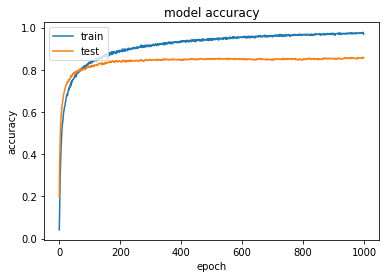

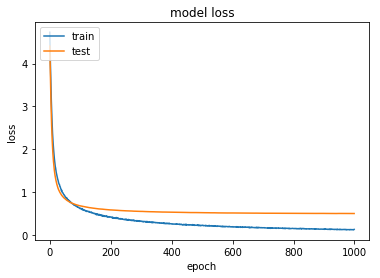

In [29]:
### TODO: Train the model.
callbacks = [
    EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True),
]

history = choosing_model.fit(train_model, train_targets, 
          validation_data=(valid_model, valid_targets),
          epochs=1000, batch_size=128, callbacks=callbacks, verbose=1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [30]:
### TODO: Load the model weights with the best validation loss.

choosing_model.load_weights('saved_models/weights.best.Resnet50.hdf5')


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [31]:
### TODO: Calculate classification accuracy on the test dataset.
model_prediction = [np.argmax(choosing_model.predict(np.expand_dims(feature, axis=0))) for feature in test_model]

test_accuracy = 100*np.sum(np.array(model_prediction)==np.argmax(test_targets, axis=1))/len(model_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.3301%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [32]:
### TODO: Write a function that takes a path to an image as input
from extract_bottleneck_features import *

def predict_dog_breed(img_path):
    # extract bottleneck features
    #print("Inside Prediction Dog Breed")
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = choosing_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]
### and returns the dog breed that is predicted by the model.

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

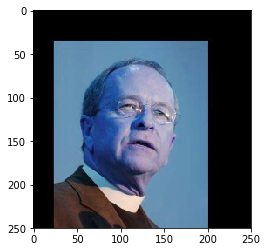

You look like a ..

American_foxhound


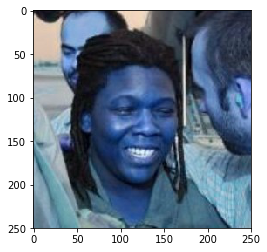

You look like a ..

American_water_spaniel


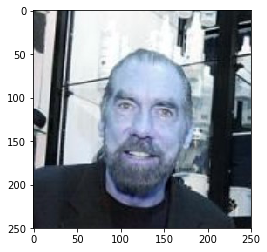

You look like a ..

American_water_spaniel


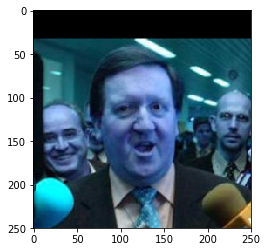

You look like a ..

Basenji


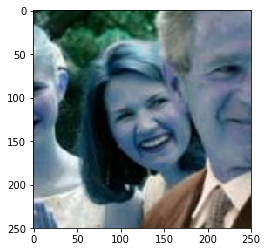

You look like a ..

American_water_spaniel


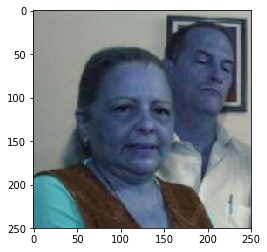

You look like a ..

American_water_spaniel


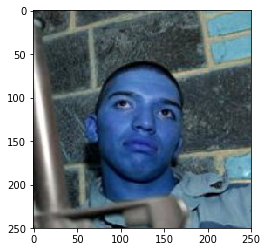

You look like a ..

Lowchen


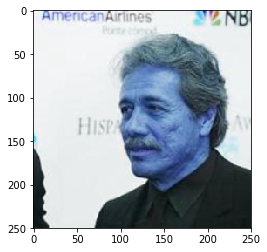

You look like a ..

American_water_spaniel


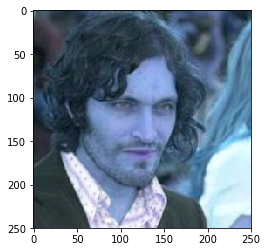

You look like a ..

American_water_spaniel


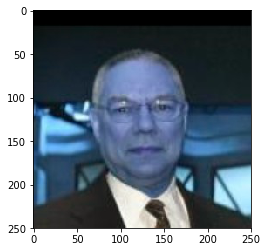

You look like a ..

American_water_spaniel


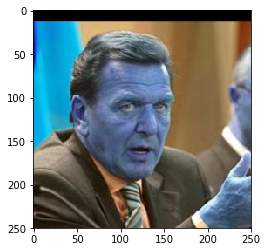

You look like a ..

Chinese_shar-pei


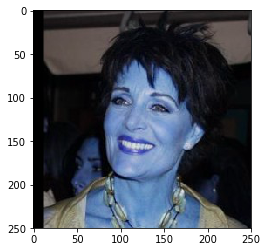

You look like a ..

English_toy_spaniel


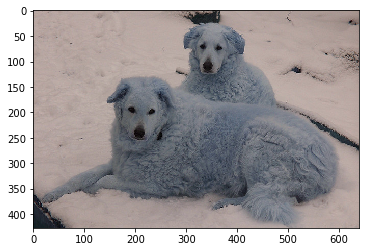

Dog breed: 
Kuvasz
Dog breed: 


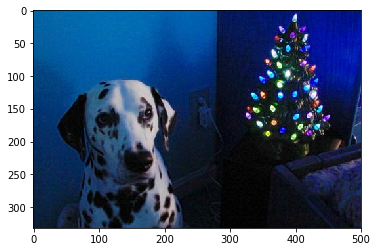

Dog breed: 
Dalmatian
Dog breed: 


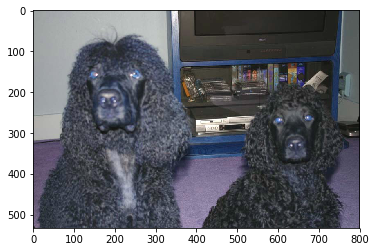

Dog breed: 
Irish_water_spaniel
Dog breed: 


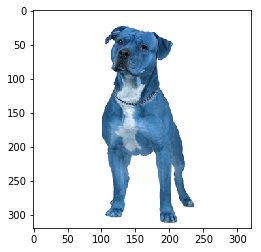

Dog breed: 
American_staffordshire_terrier
Dog breed: 


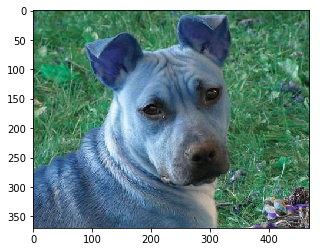

Dog breed: 
American_staffordshire_terrier
Dog breed: 


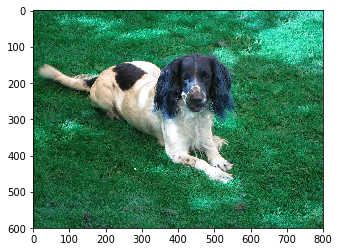

Dog breed: 
English_springer_spaniel
Dog breed: 


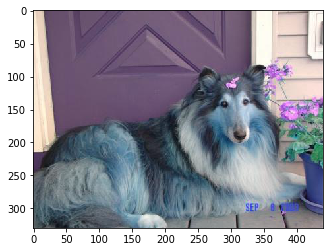

Dog breed: 
Collie
Dog breed: 


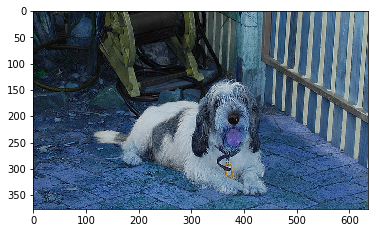

Dog breed: 
Petit_basset_griffon_vendeen
Dog breed: 


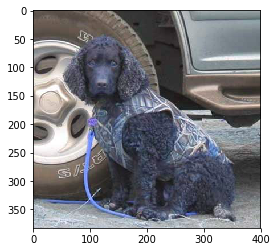

Dog breed: 
American_water_spaniel
Dog breed: 


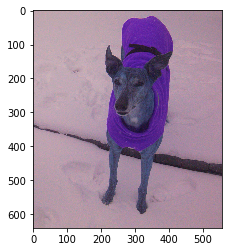

Dog breed: 
Greyhound
Dog breed: 


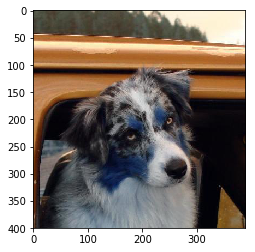

Dog breed: 
Australian_shepherd
Dog breed: 


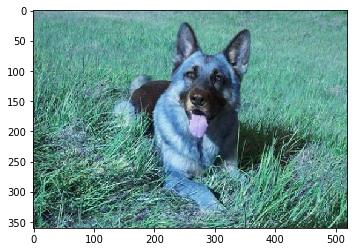

Dog breed: 
German_shepherd_dog
Dog breed: 


In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
human_files_short = human_files[:12]
dog_files_short = train_files[:12]
def identify(img_path):
    if(face_detector(img_path)):
        # load color (BGR) image
        img = cv2.imread(img_path)
        # display the image, along with bounding box
        plt.imshow(img)
        plt.show()
        print("You look like a ..\n")
        print(predict_dog_breed(img_path))
    elif(dog_detector(img_path)):
        img = cv2.imread(img_path)
        # display the image, along with bounding box
        plt.imshow(img)
        plt.show()
        print("Dog breed: ")
        print(predict_dog_breed(img_path))
        print("Dog breed: ")
    else:
        img = cv2.imread(img_path)
        # display the image, along with bounding box
        plt.imshow(img)
        plt.show()
        print("Image is not reconigzed by the system")
        
for i in range(len(human_files_short)):
    identify(human_files_short[i])
    
for i in range(len(dog_files_short)):
    identify(dog_files_short[i])

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ Actually the output the same as above problem.

In [34]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
# Image path extraction
import random
# load filenames in shuffled human dataset
human_images = np.array(glob("human_profiles/*"))
animal_images = np.array(glob("dog_profiles/*"))


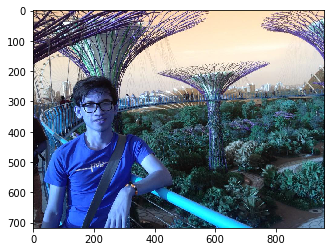

You look like a ..

Canaan_dog


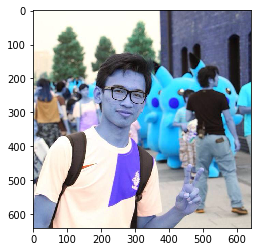

You look like a ..

Canaan_dog


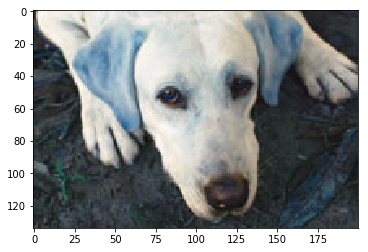

Dog breed: 
Anatolian_shepherd_dog
Dog breed: 


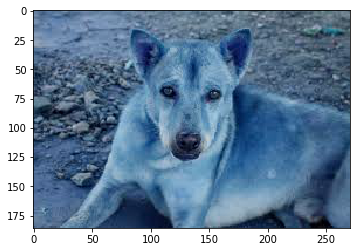

Image is not reconigzed by the system


In [36]:
# Prediction algorithm
for i in range(len(human_images)):
    identify(human_images[i])
    
for i in range(len(human_images)):
    identify(animal_images[i])